# Use BigSQL to work with Big Data residing in Object Storage

This notebook has no running code in the cells. It consists of the description 
   - how to create Db2 Big SQL objects using SQL-DDL 
   - how to use Db2 BigSQL for querying landed data in text format
   - how to write data and also use other formats with Db2 BigSQL. 
Parquet will be used to support fast SQL processing and to leverage from column compression. A sample that uses JSON format is also given.<br>
The SQL code contained below will be executed with the integrated query editor which is part of the "Data Management Console" of Cloud Pak for Data.<br>
<br>
As input source we will use preloaded textfiles from the MinIO object store which was configured in the previous section.<br>
The CSVs are from TPC-H benchmark. They use "|" (pipe) as seperator.<br>
All the source files are stored in "user00" bucket.<br> 

### [Caution] Diskspace is limited
We use an internal object storage implementation with limited ressources and without quotas. When you write data in the second part of this section please execute every "INSERT" step just once if not explicitly stated otherwise.
## Conventions and basic concepts

The source Files are all located in Bucket "user00" these files are intended to be accessed shared and read only during this lab.
Transformed data will be landed in a user specific bucket "user"\<YOUR-ID> where \<YOUR-ID> is a two digit code: your user ID with a leading zero if single digit e.g. "user01" for user 1.
BigSQL objects (i.e. tables) will be created in a user specific schema e.g. "USER01" for User 1.  

Some backround how BigSQl works: <br>
Db2 BigSQL obects names have to follow this naming convention:  

"s3a://\<bucket>/tabname/filename1"   
"s3a://\<bucket>/tabname/filename2"    
'...'     
   - "s3a" means the data is located on an object store (not e.g. a connected Hadoop Cluster, BigSQL would offer this option, but this is not part of this lab).
   - \<bucket>/ is the bucket where the referenced objects reside - bucketname is case sensitive - in our demo: all lowercase.
   - tabname must match the BigSQL tablename
   - filename are the individual objects<br>
So the objects with the same table prefix 'tabname' contain the contents of the responding table (think of "UNION ALL"), thus they are expected to have the same structure.<br>
<br>
BigSQL is robust against schema evolution (e.g. new or dropped columns), naturally this works best with formats that have (some) schema support like parquet, JSON, ...<br>

## 1 Start Db Workbench

1. From the Hamburger Menue top left choose "Services--> Instances"
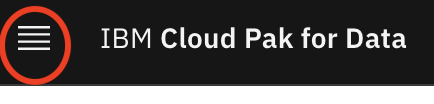
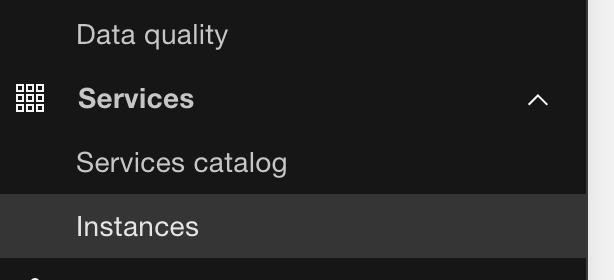
2. Then select "Open" on "Db2-Big-SQL-1"   
__[CAUTION]__ Click the button on the right as shown below. Clicking on the Db2-Big-SQL-1 hyperlink will open the configure instance screen.   
If this happens accidentially use the browsers back button or start with "Services--> Instances" from the Hamburger menu again.

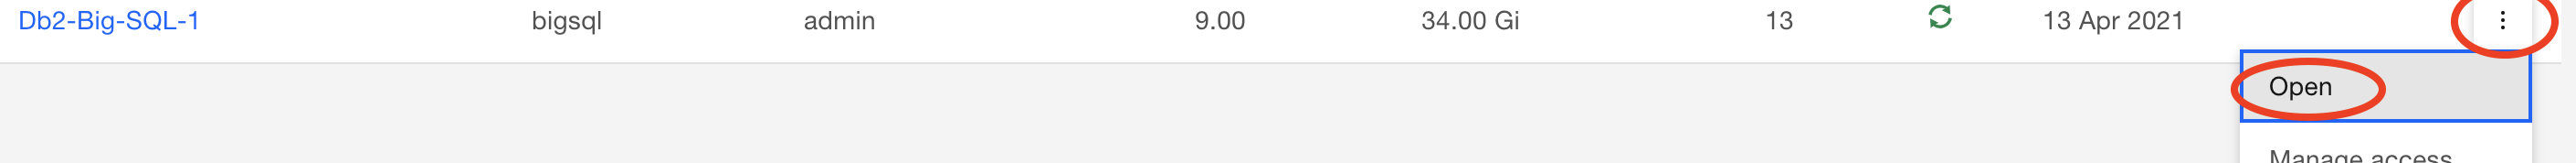
3. Checkout the Summary Page
See the available statistics on the starting page
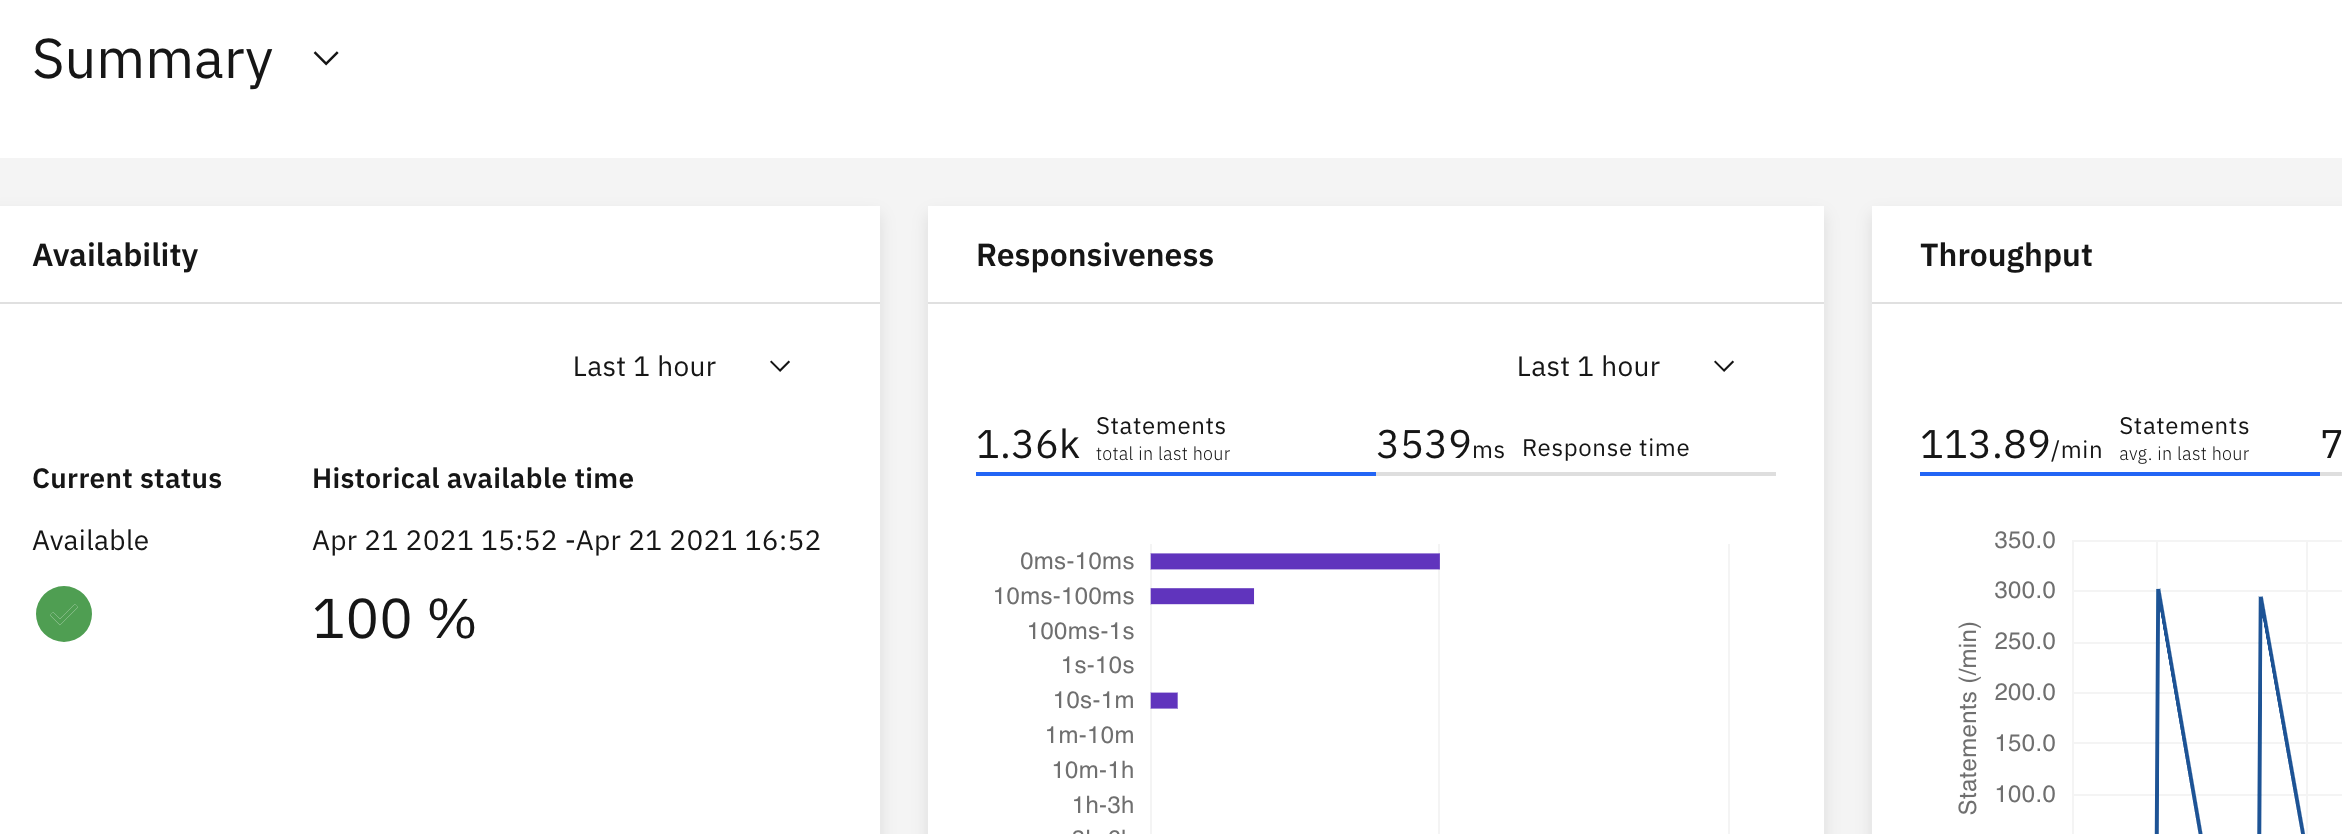

## 2 Use Db2 Big SQL to access data on object store
Create the required DB2 BigSQL objects
### Open the SQL Editor
1. From the top left continue by opening "Run SQL"
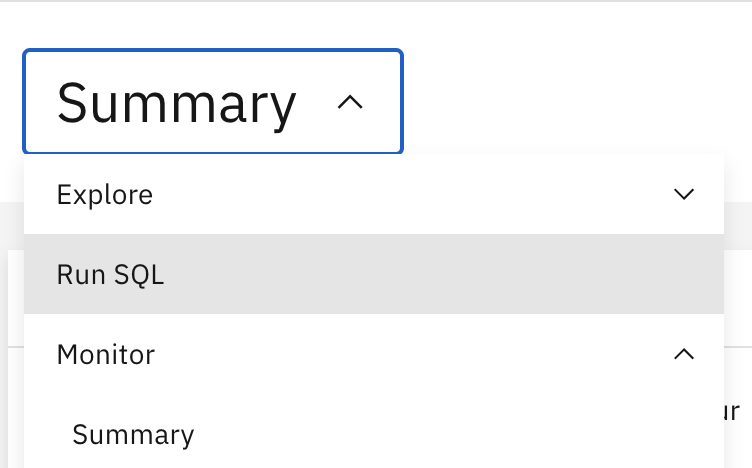
   - Click "Add new script"
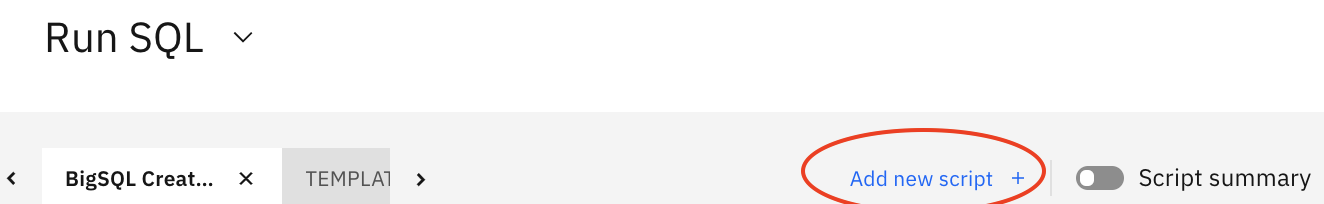
- Click "Create new"
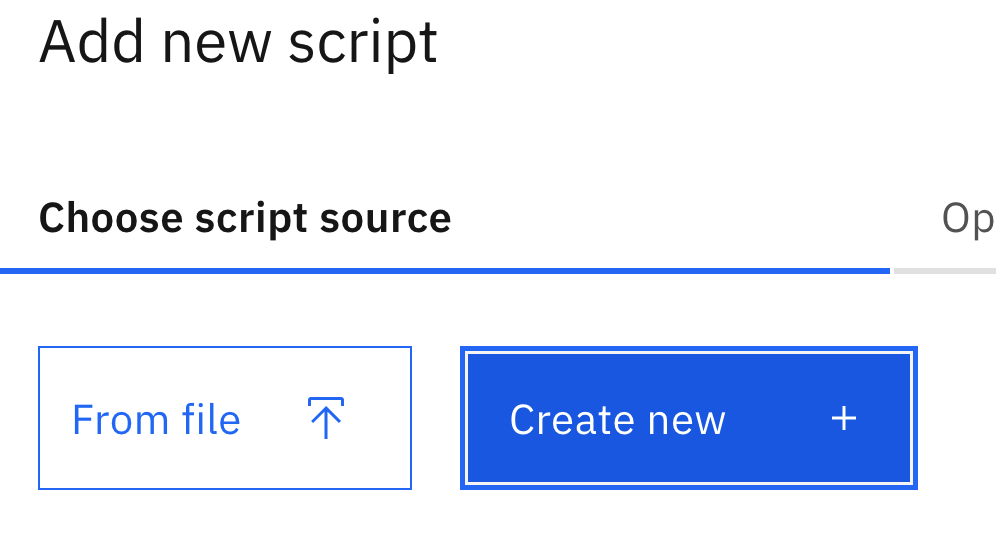

### Create Script "BigSQL Create Tables"

Copy the following code to a new script "BigSQL Create Tables"

```sql
-- Db2 BigSQL Create Tables.sql

-- A BigSQL Instance is always connected to one specifice Object Storage provider or even a single bucket
-- This obj storage provider is referenced by the "s3a" prefix (see below)

-- template create tables - CSV on S3 separated by pipe
--  CREATE external HADOOP TABLE <YOUR-TABLE-NAME> (
--)
--  ROW FORMAT DELIMITED FIELDS TERMINATED BY '|'
--  LOCATION 's3a://<BUCKET>/<FLDR>';
-- <BUCKET> and <FLDR> are case sensitive!  



-- Tasks

-- 1. Replace <SCHEMA> with "USER"<YOUR-ID> e.g. "USER01"
-- 2. Replace <bucket> with "user"<YOUR-ID> e.g. "user01"
-- where <YOUR-ID> is a two digit code: your user ID with a leading zero if single digit


--
-- Create CSV source tables
-- source contents are the same for all participiants, wjile the Db2 Object Name is specific
-- 

-- Create External Table to access ORDERS source
CREATE EXTERNAL HADOOP TABLE <SCHEMA>.ORDERS  ( 
							O_ORDERKEY       INTEGER NOT NULL,
                           O_CUSTKEY        INTEGER NOT NULL,
                           O_ORDERSTATUS    CHAR(1) NOT NULL,
                           O_TOTALPRICE     DECIMAL(15,2) NOT NULL,
                           O_ORDERDATE      DATE NOT NULL,
                           O_ORDERPRIORITY  CHAR(15) NOT NULL,  
                           O_CLERK          CHAR(15) NOT NULL, 
                           O_SHIPPRIORITY   INTEGER NOT NULL,
                           O_COMMENT        VARCHAR(79) NOT NULL
)
ROW FORMAT DELIMITED FIELDS TERMINATED BY '|'
LOCATION 's3a://user00/orders';

-- check if it was successfull
select * from <SCHEMA>.ORDERS
fetch first 5 rows only;


-- Create External Table to access LINEITEM source
CREATE EXTERNAL HADOOP TABLE <SCHEMA>.LINEITEM ( L_ORDERKEY    INTEGER NOT NULL,
                             L_PARTKEY     INTEGER NOT NULL,
                             L_SUPPKEY     INTEGER NOT NULL,
                             L_LINENUMBER  INTEGER NOT NULL,
                             L_QUANTITY    DECIMAL(15,2) NOT NULL,
                             L_EXTENDEDPRICE  DECIMAL(15,2) NOT NULL,
                             L_DISCOUNT    DECIMAL(15,2) NOT NULL,
                             L_TAX         DECIMAL(15,2) NOT NULL,
                             L_RETURNFLAG  CHAR(1) NOT NULL,
                             L_LINESTATUS  CHAR(1) NOT NULL,
                             L_SHIPDATE    DATE NOT NULL,
                             L_COMMITDATE  DATE NOT NULL,
                             L_RECEIPTDATE DATE NOT NULL,
                             L_SHIPINSTRUCT CHAR(25) NOT NULL,
                             L_SHIPMODE     CHAR(10) NOT NULL,
                             L_COMMENT      VARCHAR(44) NOT NULL
)
ROW FORMAT DELIMITED FIELDS TERMINATED BY '|'
LOCATION 's3a://user00/lineitem';

-- check if it was successfull
select * from <SCHEMA>.LINEITEM
fetch first 5 rows only;


--
-- Create PARQUET tables - these are initailly empty
-- Parquet Tables will be populated in a seperate script

-- 
-- ORDERS - Parquet

-- DROP TABLE <SCHEMA>.ORDERS_PQ;
CREATE EXTERNAL HADOOP TABLE <SCHEMA>.ORDERS_PQ  ( 
							O_ORDERKEY       INTEGER NOT NULL,
                           O_CUSTKEY        INTEGER NOT NULL,
                           O_ORDERSTATUS    CHAR(1) NOT NULL,
                           O_TOTALPRICE     DECIMAL(15,2) NOT NULL,
                           O_ORDERDATE      DATE NOT NULL,
                           O_ORDERPRIORITY  CHAR(15) NOT NULL,  
                           O_CLERK          CHAR(15) NOT NULL, 
                           O_SHIPPRIORITY   INTEGER NOT NULL,
                           O_COMMENT        VARCHAR(79) NOT NULL
)
STORED AS PARQUETFILE
LOCATION 's3a://<bucket>/orders_pq';

-- LINEITEM - Parquet

-- DROP TABLE <SCHEMA>.LINEITEM_PQ;
CREATE EXTERNAL HADOOP TABLE <SCHEMA>.LINEITEM_PQ (
							L_ORDERKEY    INTEGER NOT NULL,
                             L_PARTKEY     INTEGER NOT NULL,
                             L_SUPPKEY     INTEGER NOT NULL,
                             L_LINENUMBER  INTEGER NOT NULL,
                             L_QUANTITY    DECIMAL(15,2) NOT NULL,
                             L_EXTENDEDPRICE  DECIMAL(15,2) NOT NULL,
                             L_DISCOUNT    DECIMAL(15,2) NOT NULL,
                             L_TAX         DECIMAL(15,2) NOT NULL,
                             L_RETURNFLAG  CHAR(1) NOT NULL,
                             L_LINESTATUS  CHAR(1) NOT NULL,
                             L_SHIPDATE    DATE NOT NULL,
                             L_COMMITDATE  DATE NOT NULL,
                             L_RECEIPTDATE DATE NOT NULL,
                             L_SHIPINSTRUCT CHAR(25) NOT NULL,
                             L_SHIPMODE     CHAR(10) NOT NULL,
                             L_COMMENT      VARCHAR(44) NOT NULL
)
STORED AS PARQUETFILE
LOCATION 's3a://<bucket>/lineitem_pq';


--
-- Create JSON tables - these are initailly empty
-- JSON Tables will be populated in a seperate script

-- DROP TABLE <SCHEMA>.ORDERS_JSON;
CREATE EXTERNAL HADOOP TABLE <SCHEMA>.ORDERS_JSON ( 
							O_ORDERKEY       INTEGER NOT NULL,
                           O_CUSTKEY        INTEGER NOT NULL,
                           O_ORDERSTATUS    CHAR(1) NOT NULL,
                           O_TOTALPRICE     DECIMAL(15,2) NOT NULL,
                           O_ORDERDATE      DATE NOT NULL,
                           O_ORDERPRIORITY  CHAR(15) NOT NULL,  
                           O_CLERK          CHAR(15) NOT NULL, 
                           O_SHIPPRIORITY   INTEGER NOT NULL,
                           O_COMMENT        VARCHAR(79) NOT NULL
)
ROW FORMAT SERDE 'org.apache.hive.hcatalog.data.JsonSerDe'
LOCATION 's3a://<bucket>/orders_json';
```
Save the script
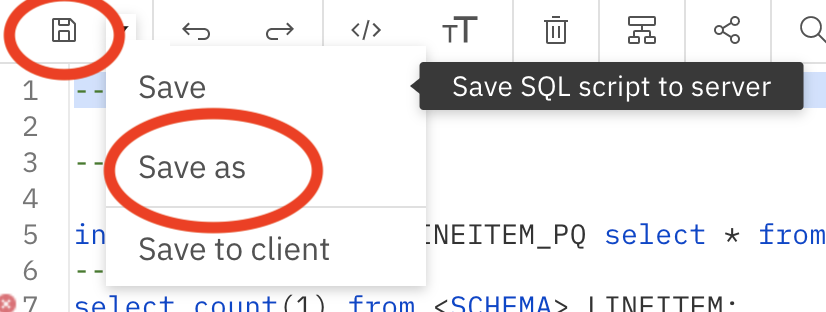   

### Steps Edit Script
You will create the BigSQL objects in your specific schema. For the csv (import) part this points to the shared "user00" bucket". The parquet / write part will use your own bucket. 
Follow the steps as described in thge SQL code. You may invoke each statement one by one by selecting the statement and issue "Run Selected". You need to select all lines of a statement (e.g. from "CREATE TABLE ..." until the semicolon) and then click "Run Selected".
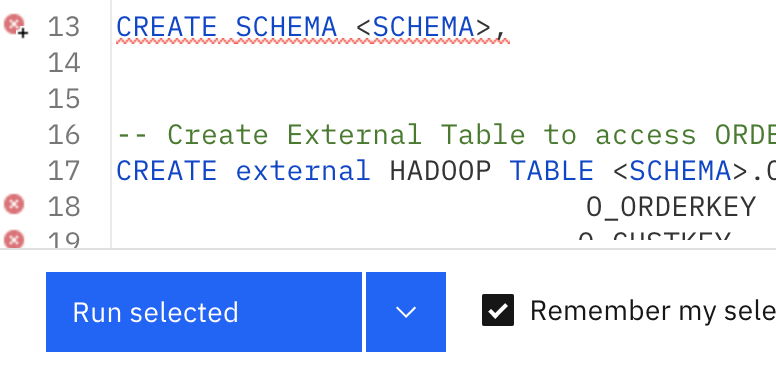

Steps:
1. Replace \<SCHEMA\> with your schema name (USER\<YOUR-ID>)
2. Replace \<bucket\> with your bucket name
2. Issue CREATE TABLE ... ORDERS statement to create a HADOOP table in your USERNN Schema, to query the preloaded CSV data 
2. Issue an SELECT statement to verify this was successfull
3. Issue CREATE TABLE ... ORDERS_PQ statement to cretate an HADOOP table that uses parquet format
4. Issue an SELECT statement to verify the parquet table successfully created
1. repeat the steps for LINEITEM and LINEITEM PQ

### [optional] Reopen your saved script
If you save and leave the editor (close the tab), you can open the script later with the following steps:
Open the DB Workbench:
   - From the Hamburger Menue top left choose "Services --> Instances"
   - Then select "Open" on "Db2-Big-SQL-1"
   - From the top left continue by opening "Run SQL"
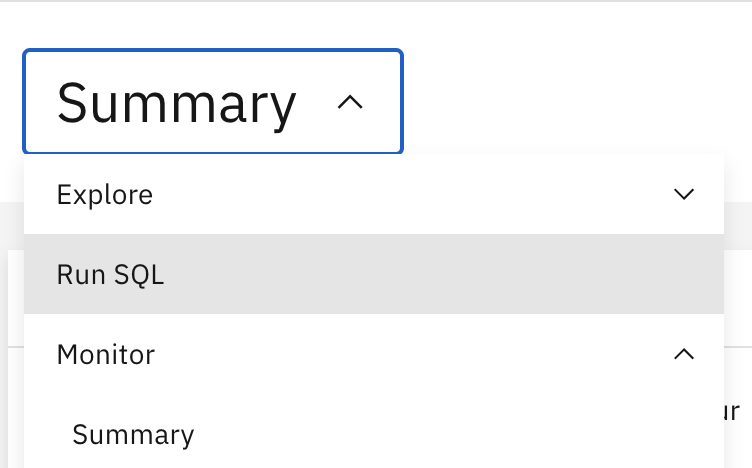
   - to the right click "Add New Script" 
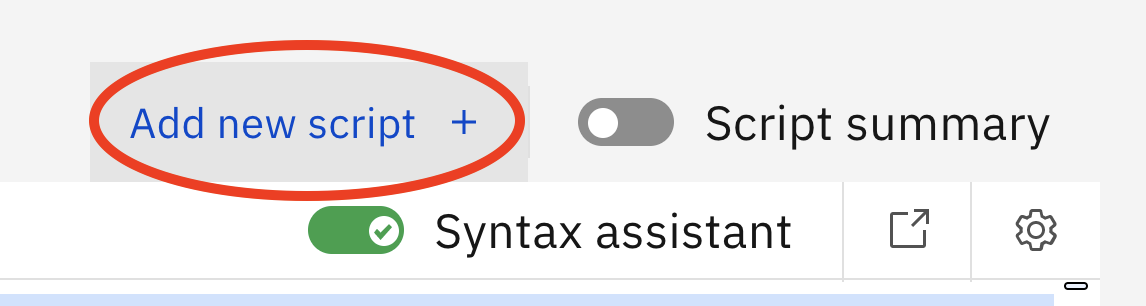
   - Click "Open a script to edit" 
   - Scroll down to your script and click the open button to the right 
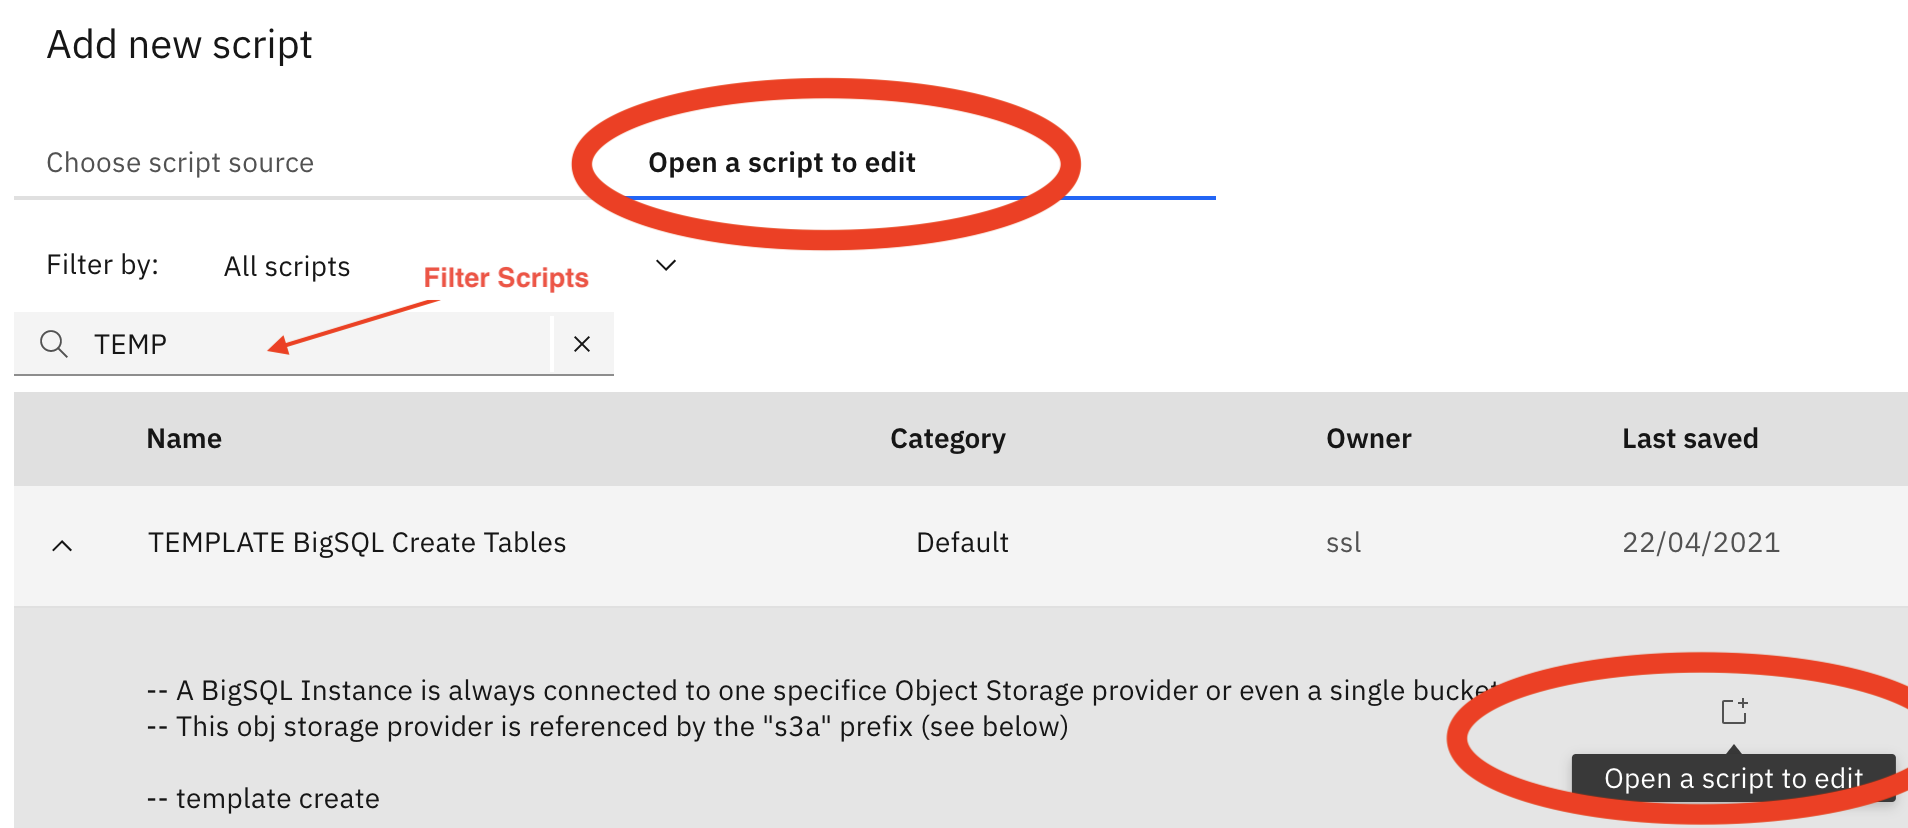   
    
## 3 Use Db2 Big SQL to write data

### Populate the created parquet tables
Copy the following code to a new script "BigSQL Populate Tables.sql".<br>
As in the previous example each statement should be issued one by one.<br>

```sql 
-- Db2 BigSQL Populate Tables.sql


-- Section 0 Prepare

-- 1. Replace <SCHEMA> with "USER"<YOUR-ID> e.g. "USER01"

--
-- Section 1 Parquet
--

-- ORDERS table

insert into <SCHEMA>.ORDERS_PQ SELECT * FROM USER00.ORDERS;
-- check
select count(1) from <SCHEMA>.ORDERS;
select count(1) from <SCHEMA>.ORDERS_PQ;
SELECT * FROM <SCHEMA>.ORDERS_PQ


-- LINEITEM table

-- populate

insert into <SCHEMA>.LINEITEM_PQ SELECT * FROM USER00.LINEITEM;
-- check
select count(1) from <SCHEMA>.LINEITEM;
select count(1) from <SCHEMA>.LINEITEM_PQ;
SELECT * FROM <SCHEMA>.LINEITEM_PQ

--
-- Section 2 JSON
--
-- populate table
insert into <SCHEMA>.ORDERS_JSON 
select * from USER00.orders FETCH FIRST 10 rows only;

-- play around 
select sum(O_TOTALPRICE) from <SCHEMA>.ORDERS_JSON;
select sum(O_TOTALPRICE) from <SCHEMA>.ORDERS_PQ;

-- compare counts
select count(1) cnt, 'CSV' tab from USER00.ORDERS
union all
select count(1) cnt, 'JSON' from <SCHEMA>.ORDERS_JSON
union all
select count(1) cnt, 'PARQET' from <SCHEMA>.ORDERS_PQ;
```
Steps<br>
1. Create the ETL Template
   - Create the Script "BigSQL Populate Tables" as for the create-script with the above code
   - Save it to "BigSQL Populate Tables"
   - Replace \<SCHEMA\> with your schema name (USER\<YOUR-ID>)
   - Replace \<bucket\> with your bucket name (bucket\<YOUR-ID>) 
   - !! bucket is case-sensitive - lowercase<br>
2. Run statement to copy data from CSV input into the parquet table
    - "INSERT INTO USER\<YOUR-ID>.ORDERS_PQ FROM SELECT * FROM USER00.ORDERS" 
    - \[CAUTION\] every time you do an "INSERT ... FROM .. SELECT ..." a new file will be written and diskspace could be an issue if you do this to often. 
3. Query parquet table
    - SELECT * FROM USER\<YOUR-ID>.ORDERS_PQ
    - SELECT count(*) FROM USER\<YOUR-ID>.ORDERS_PQ
4. Check created files in MinIO Browser 
    - Open Minio Browser in separate tab   
    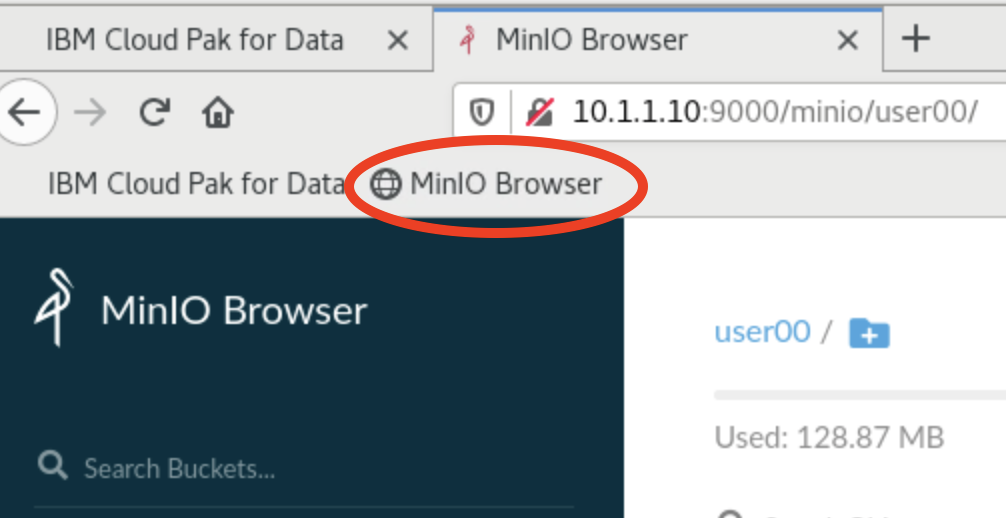    
    - login with Access Key = user\<YOUR-ID>, Secret Key = passuser\<YOUR-ID>
    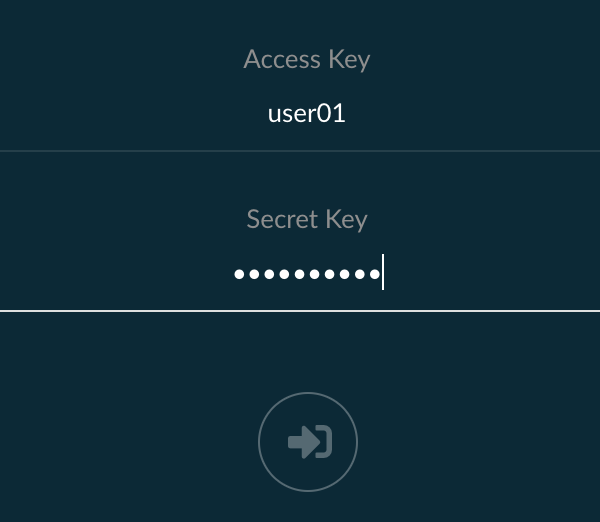
    - navigate to s3a://user\<YOUR-ID>/orders_pq
    - see the created files
5. [optional] Add some more contents
    - INSERT INTO USER\<YOUR-ID>.ORDERS_PQ again
    - verify the created Objects in MinIO Browser again
    - SELECT count(*) FROM USER\<YOUR-ID>.ORDERS_PQ
    - delete object from previous step in Minio Browser
    - see result of SELECT count(*) FROM USER\<YOUR-ID>.ORDERS_PQ 
6. DROP TABLE ORDERS

### Populate the JSON Table with some lines
1. Issue CREATE TABLE ... ORDERS_JSON statement 
2. Issue an SELECT statement to verify this was successfull
3. Insert some lines
    - "INSERT INTO USER\<YOUR-ID>.ORDERS_JSON FROM SELECT * FROM USER00.ORDERS"
4. Download JSON file using MinIO browser 
    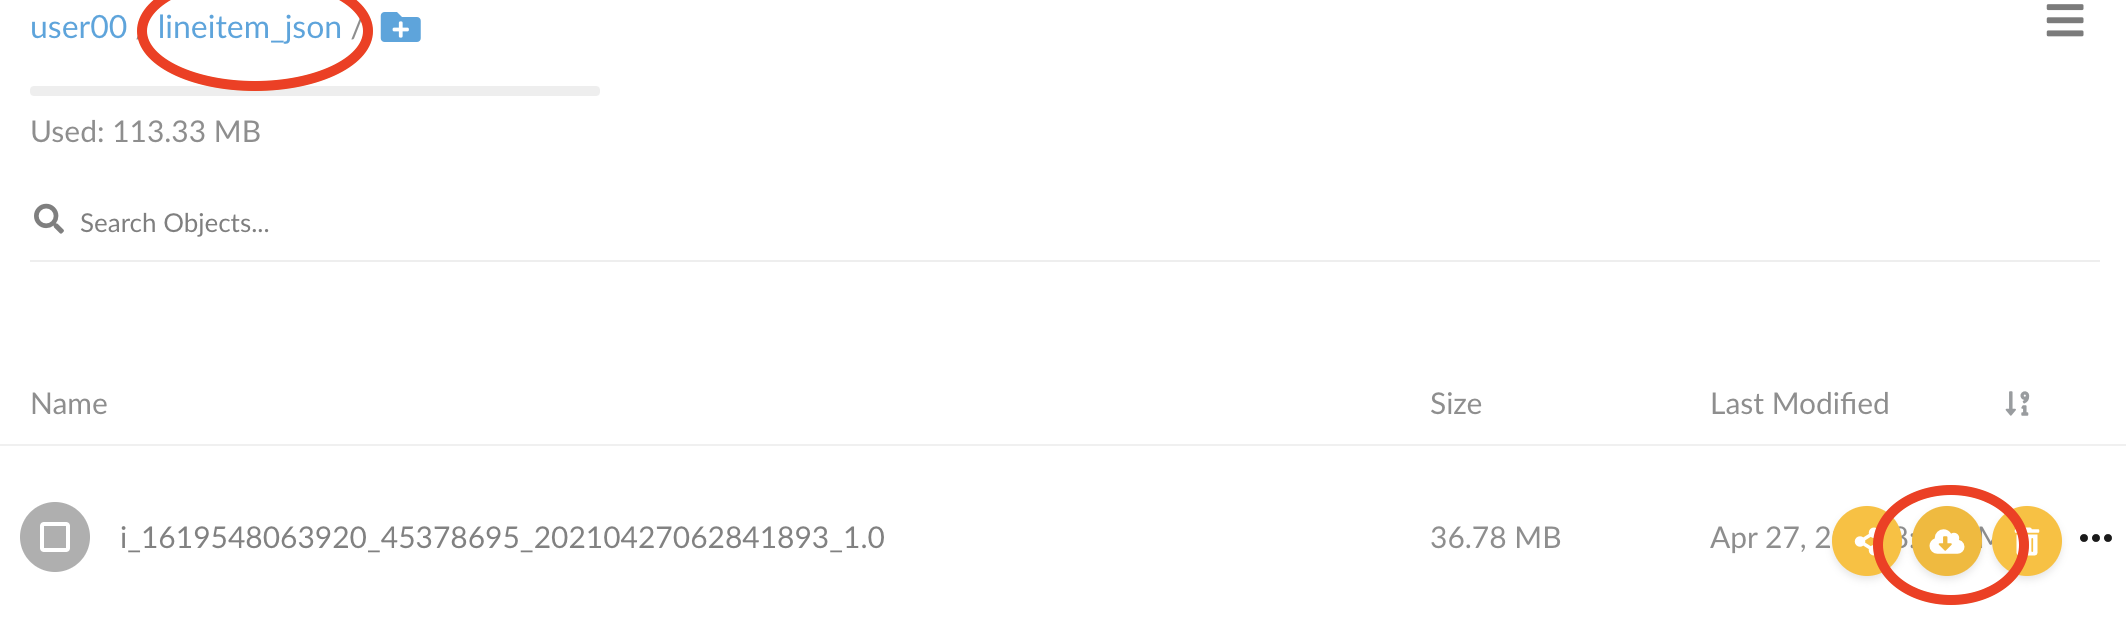
    - navigate to downloads folder
    - check file contents with your editor of choice
    - verify JSON formatting
5. [optional] see using complex / nested structures with JSON
    - check https://www.ibm.com/docs/sl/db2-big-sql/5.0.1?topic=types-big-sql-complex-data-json-data


This concludes 23-BigSQL-ETL continue with 25-BigSQL-Jupyter-Demo

**This project contains Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2021. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.<br>**